# Setup 

In [1]:
%matplotlib notebook

import sys
import os
import time
import numpy as np
import matplotlib as mpl

from collections import OrderedDict
from importlib import reload
from matplotlib import pyplot as plt

In [2]:
import qcodes as qc
import broadbean as bb

from broadbean.plotting import plotter

In [3]:
from qcodes import load_by_id
from qcodes import validators
from qcodes.instrument.base import Instrument
from qcodes.dataset.measurements import Measurement
from qcodes.instrument.parameter import Parameter
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.data_set import DataSet
from qcodes.sweep import sweep, nest, chain, szip, getter, setter
from qcodes.sweep.sweep import ParameterSweep, Nest, ParameterWrapper, FunctionWrapper, FunctionSweep, getter

In [4]:
from pytopo.qctools import instruments as instools; reload(instools)
from pytopo.qctools.instruments import create_inst, add2station

from pytopo.qctools import measurement; reload(measurement)
from pytopo.qctools.measurement import MeasurementExt

from pytopo.mplplots.init_nb_plotting import *
from pytopo.mplplots import plots as mplplots
from pytopo.mplplots import tools as mpltools

from pytopo.qctools.dataset2 import select_experiment

import plottr; reload(plottr)
from plottr import client
from plottr.qcodes_dataset import QcodesDatasetSubscriber

from pytopo.mplplots.init_nb_plotting import *

qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments.db"

In [5]:
from pytopo.qctools import hard_sweep; reload(hard_sweep)
from pytopo.qctools.hard_sweep import HardSweep, HardSweepDetector

## Classes

In [88]:
class ConversionParameter(Parameter):
    
    def __init__(self, name, src_param, get_conv, set_conv=None, **kw):
        super().__init__(name, **kw)
        self.src_param = src_param
        self.get_conv = get_conv
        self.set_conv = set_conv
    
    def get_raw(self):
        return self.get_conv(self.src_param())
    
    def set_raw(self, value):
        if self.set_conv is None:
            raise NotImplementedError("No set conversion implemented.")
        
        return self.src_param(self.set_conv(value))
    

class IVVISetup(Instrument):
    
    def __init__(self, name, ivvi, **kw):
        super().__init__(name, **kw)
        
        self.ivvi = ivvi
        
        self.add_parameter('voltage_multiplier', get_cmd=None, set_cmd=None, 
                           initial_value=10e-3)
        self.add_parameter('current_multiplier', get_cmd=None, set_cmd=None, 
                           initial_value=1e-7)
        self.add_parameter('iso_in_multiplier', get_cmd=None, set_cmd=None,
                           initial_value=1e-2)
        self.add_parameter('gate_multiplier', get_cmd=None, set_cmd=None, 
                           initial_value=1)
        
        self.add_parameter('M1b_gain', get_cmd=None, set_cmd=None, initial_value=1e6)
        self.add_parameter('M1b_mode', get_cmd=None, set_cmd=None, 
                           vals=validators.Enum('low_noise', 'low_R_in'), 
                           initial_value='low_noise')
        self.add_parameter('M1b_R_in', get_cmd=self._get_M1b_R_in)
        
        self.add_parameter('M2m_Vgain', get_cmd=None, set_cmd=None, initial_value=1e3)

        for i in range(1, self.ivvi._numdacs + 1):       
            self.add_parameter('dac{}'.format(i), unit='V',
                               get_cmd=self.ivvi._gen_ch_get_func(self._get_dac, i),
                               set_cmd=self.ivvi._gen_ch_set_func(self._set_dac, i))
            
    def _get_M1b_R_in(self):
        if self.M1b_mode() == 'low_noise':
            return 2e3 + 1e-3 * self.M1b_gain()
        elif self.M1b_mode() == 'low_R_in':
            return 2e3 + 1e-4 * self.M1b_gain()
            
    def _get_dac(self, ch):
        if ch in [8, 9, 10, 11, 12, 13, 14, 15]:
            return self.ivvi.set('dac{}'.format(ch)) * 1e-3 * self.gate_multiplier()
        else:
            return self.ivvi.get('dac{}'.format(ch)) * 1e-3 * self.voltage_multiplier()
    
    def _set_dac(self, ch, val):
        if ch in [8, 9, 10, 11, 12, 13, 14, 15]:
            return self.ivvi.set('dac{}'.format(ch), val * 1e3 / self.gate_multiplier())
        else:
            return self.ivvi.set('dac{}'.format(ch), val * 1e3 / self.voltage_multiplier())

### AWG

In [7]:
ramp = bb.PulseAtoms.ramp

class BluePrints(object):
    
    def __init__(self, chan_map, sample_rate=1e9):
        self.bps = {}
        self.map = {}
        
        for i, lst in chan_map.items():
            self.bps[i] = bb.BluePrint()
            self.bps[i].setSR(sample_rate)
            for j, name in enumerate(lst):
                if name is not None:
                    self.map[name] = (i, j)
                    
    def __getitem__(self, name):
        if self.map[name][1] == 0:
            return self.bps[self.map[name][0]]
        else:
            return getattr(self.bps[self.map[name][0]], 'marker{}'.format(self.map[name][1]))
        
    def __setitem__(self, name, value):
        if self.map[name][1] == 0:
            self.bps[self.map[name][0]] = value
        else:
            setattr(self.bps[self.map[name][0]], 'marker{}'.format(self.map[name][1]), value)
        
    def __call__(self):
        return list(self.bps.items())
    

class BroadBeanSequence(HardSweep):
    
    chan_map = {}
    
    def __init__(self, name, awg, chan_map, **kw):
        self.awg = awg
        self.chan_map = chan_map
        
        super().__init__(name, **kw)
        
        self.add_parameter('sample_rate', get_cmd=None, set_cmd=None, 
                           unit='GS/s', initial_value=1e9)
        
    def sequence(self):
        raise NotImplementedError
        
        
    def setup(self, program_awg=True, start_awg=True):
        super().setup()
        
        self.awg.stop()
        
        if program_awg:
            self.awg.clock_freq(self.sample_rate())
            seq = self.sequence()
            pkg = seq.outputForAWGFile()
            self.awg.make_send_and_load_awg_file(*pkg[:])
        
            for ch_no, ch_desc in self.chan_map.items():
                self.awg.set('ch{}_state'.format(ch_no), 1)

        if start_awg:
            self.awg.start()

        
class AWGGateRamp1D(BroadBeanSequence):
    
    trigger_delay = 100e-9
    alazar_trigger_len = 100e-9
    
    def __init__(self, *arg, **kw):
        
        kw['sweep_dims'] = ['voltage_vals', ]
        
        super().__init__(*arg, **kw)
        
        self.add_parameter('step_len', set_cmd=None, 
                           unit='s', initial_value=10e-6)
        self.add_parameter('start_voltage', set_cmd=None,
                           unit='V', initial_value=0)
        self.add_parameter('stop_voltage', set_cmd=None,
                           unit='V', initial_value=1)
        self.add_parameter('voltage_points', set_cmd=None,
                           unit='', initial_value=11)
        self.add_parameter('ramp_down_time', set_cmd=None,
                           unit='s', initial_value=10e-6)
        
    def setup(self, **kw):
        vpts = np.linspace(self.start_voltage(), self.stop_voltage(), self.voltage_points())
        self.voltage_vals(vpts)
        super().setup(**kw)
        
        
    def sequence(self):
        elem = bb.Element()
        bps = BluePrints(self.chan_map, sample_rate=self.sample_rate())
        
        cut_t = 0
#         bps['awg_voltage'] = []
        bps['alz_mrkr'] = []
        for i, v in enumerate(self.voltage_vals()):
            bps['awg_voltage'].insertSegment(i, ramp, (v, v), 
                                             dur=self.step_len(), name='voltage')
            bps['alz_mrkr'].append((self.step_len() * i + self.trigger_delay, self.alazar_trigger_len))
            
        bps['awg_voltage'].insertSegment(-1, ramp, (v, self.start_voltage()), 
                                         dur=self.ramp_down_time(), name='voltage')        
            
        
        for n, bp in bps():
            elem.addBluePrint(n, bp)
            
        seq = bb.Sequence()
        seq.name = 'v_ramp'
        seq.addElement(1, elem)
        seq.setSR(self.sample_rate())
        
        seq.setChannelAmplitude(1, 1)
        seq.setChannelOffset(1, 0)
        seq.setChannelAmplitude(2, 1)
        seq.setChannelOffset(2, 0)

        seq.setSequencingTriggerWait(1, 0)
        seq.setSequencingGoto(1, 1)
        
        return seq
        
        
class SimpleAWGSpec(BroadBeanSequence):

    def __init__(self, *arg, **kw):
        
        kw['sweep_dims'] = ['awg_sweep_idx', ]
        
        super().__init__(*arg, **kw)
        
        self.add_parameter('initial_delay', set_cmd=None,
                           unit='s', initial_value=1e-6)
        self.add_parameter('alazar_trigger_len', set_cmd=None,
                           unit='s', initial_value=1e-7)
        self.add_parameter('alazar_trigger_delay', set_cmd=None, 
                           unit='s', initial_value=1e-6)
        self.add_parameter('seq_len', set_cmd=None, 
                           unit='s', initial_value=1e-5)
        self.add_parameter('final_delay', set_cmd=None,
                           unit='s', initial_value=1e-6)

    def setup(self, **kw):
        self.awg_sweep_idx([1,])
        super().setup(**kw)
        
    def sequence(self):
        elem = bb.Element()
        
        bps = BluePrints(self.chan_map, sample_rate=self.sample_rate())
        
        bps['ro'].insertSegment(0, ramp, (0, 0), dur=self.seq_len(), name='ro_segment')
        bps['alz_mrkr'] = [(self.initial_delay(), self.alazar_trigger_len())]
#         bps['ro_mrkr'] = [(self.initial_delay() + self.alazar_trigger_delay(), 
#                            self.seq_len() - self.initial_delay() - 2 * self.alazar_trigger_delay() - self.final_delay(), )]
        
#         bps['test'].insertSegment(0, ramp, (0, 0), dur=self.seq_len(), name='q_segment')
#         bps['q_mrkr'] = [(self.initial_delay() + self.alazar_trigger_delay(), 
#                           self.seq_len() - self.initial_delay() - 2 * self.alazar_trigger_delay() - self.final_delay(), )]
        
        
        for n, bp in bps():
            elem.addBluePrint(n, bp)
            
        seq = bb.Sequence()
        seq.name = 'spec'
        seq.addElement(1, elem)
        seq.setSR(self.sample_rate())
        
        seq.setChannelAmplitude(1, 1)
        seq.setChannelOffset(1, 0)
        seq.setChannelAmplitude(2, 1)
        seq.setChannelOffset(2, 0)

        seq.setSequencingTriggerWait(1, 0)
        seq.setSequencingGoto(1, 1)
        
        return seq

### Alazar

In [8]:
class AlazarBaseDetector(HardSweepDetector):
    
    def __init__(self, name, acqctl, sweep_params=['buffers', 'records'], **kwargs):
        self.acqctl = acqctl        
        self._time = None
        self._signal_real = None
        self._signal_imag = None
        self._signal_abs = None

        inner_dims = []
        for d in self.acqctl.data_dims():
            if d not in sweep_params:
                inner_dims.append(d)
        
        super().__init__(name, inner_dims=inner_dims, **kwargs)
        
        self.add_parameter('acquisition', get_cmd=self.do_acquisition, unit='V', snapshot_value=False)
        self.add_parameter('signal_real', get_cmd=lambda: self._signal_real, unit='V', snapshot_value=False)
        self.add_parameter('signal_imag', get_cmd=lambda: self._signal_imag, unit='V', snapshot_value=False)
        self.add_parameter('signal_abs', get_cmd=lambda: self._signal_abs, unit='V', snapshot_value=False)
        self.data_params = [self.signal_real, self.signal_imag, self.signal_abs]
        
        if 'samples' in self.inner_dims or 'IF_periods' in self.inner_dims:
            self.add_parameter('time', unit='s', snapshot_value=False, 
                               get_cmd=lambda: self._time)

    def setup(self):
        ### TODO:
        # We should have an option that it's possible to not specify all dimensions,
        # and basically set the shape to (-1, xxx), i.e., set the first one automatic.
        # that might then be an implicit averaging dimension, for example.
        # then sweepers can be used for both avering over buffers, or single-shot        
        for d in self.inner_dims:
            idx = self.acqctl.data_dims().index(d)
            try:
                npts = self.acqctl.data_shape()[idx]
            except:
                npts = 1
            self.set(d, np.arange(npts))
            
        super().setup()
    
    
    def do_acquisition(self):
        data = self.acqctl.acquisition()
        self.setup()
        
        if 'samples' in self.inner_dims:
            self._time = self.acqctl.tvals
        elif 'IF_periods' in self.inner_dims:
            self._time = self.acqctl.demod_tvals
            
        self._signal_real = np.real(data)
        self._signal_imag = np.imag(data)
        self._signal_abs = np.abs(data)
        
        return data

    
class AlazarDetector(AlazarBaseDetector):
    
    def __init__(self, name, acqctl, **kwargs):
        kwargs['sweep_params'] = ['buffers', 'records']
        
        super().__init__(name, acqctl, **kwargs)
        
        self.add_parameter('avg_buffers', set_cmd=None, initial_value=True)
        self.add_parameter('acq_time', 
                           get_cmd=lambda: self.acqctl.acq_time(), 
                           set_cmd=lambda x: self.acqctl.acq_time(x))
        
        if hasattr(self.acqctl, 'demod_frq'):
            self.add_parameter('demod_frq', 
                               get_cmd=lambda: self.acqctl.demod_frq(), 
                               set_cmd=lambda x: self.acqctl.demod_frq(x))
        
    def configure_alazar(self, **kwargs):
        defaults = dict(
            buffer_timeout = 10000,
            allocated_buffers = 1,
        )
        defaults.update(kwargs)
        self.acqctl.update_acquisitionkwargs(**defaults)
        
    def do_acquisition(self):
        data = super().do_acquisition()
        
        if self.avg_buffers():
            bidx = self.acqctl.data_dims().index('buffers')
            data = data.mean(axis=bidx)
            
            self._signal_real = np.real(data)
            self._signal_imag = np.imag(data)
            self._signal_abs = np.abs(data)
            
        return data

In [9]:
class HeterodyneSource(Instrument):
    
    def __init__(self, name, RF, LO, *arg, **kw):
        super().__init__(name, *arg, **kw)
        
        self.RF = RF
        self.LO = LO
        
        self.add_parameter('IF', set_cmd=None, initial_value=8e6)
        self.add_parameter('frequency', unit='Hz',
                           get_cmd=self.RF.frequency, 
                           set_cmd=self._set_freq)
        
        self.frequency(self.frequency())
    
    def _set_freq(self, frq):
        self.RF.frequency(frq)
        self.LO.frequency(frq-self.IF())
        

## Init instruments

In [10]:
from qcodes.instrument_drivers.QuTech.IVVI import IVVI
ivvi = create_inst(IVVI, "ivvi", "ASRL5::INSTR")

from qcodes.instrument_drivers.Keysight.Keysight_34465A import Keysight_34465A
key1 = create_inst(Keysight_34465A, "key1", "TCPIP::169.254.4.62::INSTR", force_new_instance=True)
key2 = create_inst(Keysight_34465A, "key2", "TCPIP::169.254.4.61::INSTR", force_new_instance=True)

from qcodes.instrument_drivers.stanford_research.SR860 import SR860
lockin1 = create_inst(SR860, "lockin1", "GPIB0::3::INSTR")

for i in range(1,16):
    ivvi.parameters['dac{}'.format(i)].set_step(2)
    ivvi.parameters['dac{}'.format(i)].set_delay(0.001)

ivvi.dac4.set_delay(0.001)
ivvi.dac4.set_step(20)

from qcodes.instrument_drivers.american_magnetics.AMI430 import AMI430,AMI430_3D
ami_x = create_inst(AMI430, "AMI430_x", "169.254.144.4", port = 7180, has_current_rating=True)
ami_y = create_inst(AMI430, "AMI430_y", "169.254.97.253", port = 7180, has_current_rating=True)
ami_z = create_inst(AMI430, "AMI430_z", "169.254.86.244", port = 7180, has_current_rating=True)

ami = create_inst(AMI430_3D, "AMI430", ami_x, ami_y, ami_z, 2)


### Init instruments
from pytopo.rf import alazar_acquisition; reload(alazar_acquisition)
from pytopo.rf.alazar_acquisition import RawAcqCtl, AvgBufCtl, AvgDemodCtl, AvgIQCtl, DemodAcqCtl, IQAcqCtl, DemodRelAcqCtl, IQRelAcqCtl

inst_list = []

from qcodes.instrument_drivers.AlazarTech.ATS9360 import AlazarTech_ATS9360
alazar = instools.create_inst(AlazarTech_ATS9360, 'alazar')
inst_list.append(alazar)

raw_acq = instools.create_inst(RawAcqCtl, 'raw_acq', 'alazar', force_new_instance=True)
inst_list.append(raw_acq)

avg_acq = instools.create_inst(AvgBufCtl, 'avg_acq', 'alazar', force_new_instance=True)
inst_list.append(avg_acq)

avgdemod_acq = instools.create_inst(AvgDemodCtl, 'avgdemod_acq', 'alazar', force_new_instance=True)
inst_list.append(avgdemod_acq)

avgiq_acq = instools.create_inst(AvgIQCtl, 'avgiq_acq', 'alazar', force_new_instance=True)
inst_list.append(avgiq_acq)

demod_acq = instools.create_inst(DemodAcqCtl, 'demod_acq', 'alazar', force_new_instance=True)
inst_list.append(demod_acq)

demodrel_acq = instools.create_inst(DemodRelAcqCtl, 'rel_acq', 'alazar', force_new_instance=True)
inst_list.append(demodrel_acq)

iqrel_acq = instools.create_inst(IQRelAcqCtl, 'iqrel_acq', 'alazar', force_new_instance=True)
inst_list.append(iqrel_acq)

iq_acq = instools.create_inst(IQAcqCtl, 'iq_acq', 'alazar', force_new_instance=True)
inst_list.append(iq_acq)

from qcodes.instrument_drivers.tektronix.AWG5014 import Tektronix_AWG5014
awg5014 = instools.create_inst(Tektronix_AWG5014, 'awg5014', address="TCPIP0::169.254.183.196::inst0::INSTR")
inst_list.append(awg5014)

from qcodes.instrument_drivers.rohde_schwarz.SGS100A import RohdeSchwarz_SGS100A
LO = instools.create_inst(RohdeSchwarz_SGS100A, 'LO', address="TCPIP0::169.254.234.107")
RF = instools.create_inst(RohdeSchwarz_SGS100A, 'RF', address="TCPIP0::169.254.2.20")

het_src = instools.create_inst(HeterodyneSource, 'het_src', LO=LO, RF=RF)
inst_list.append(het_src)

inst_list.append(ivvi)
inst_list.append(key1)
inst_list.append(key2)
inst_list.append(lockin1)
inst_list.append(ami)

Initialized IVVI-rack in 0.10s
Connected to: Keysight Technologies 34465A (serial:MY57503135, firmware:A.02.14-02.40-02.14-00.49-03-01) in 0.13s
Connected to: Keysight Technologies 34465A (serial:MY57503556, firmware:A.02.14-02.40-02.14-00.49-03-01) in 0.12s
Connected to: Stanford_Research_Systems SR860 (serial:003104, firmware:V1.47) in 0.07s


d:\onedrive\bf1\code\qcodes\qcodes\instrument\parameter.py:518: UserWarning: set_step is deprecated use step property as in `inst.step = stepvalue` instead
  "set_step is deprecated use step property as in `inst.step = "
d:\onedrive\bf1\code\qcodes\qcodes\instrument\parameter.py:530: UserWarning: set_delay is deprecated use inter_delay or post_delay property as in `inst.inter_delay = delayvalue` instead
  "set_delay is deprecated use inter_delay or post_delay property "


Connected to: AMERICAN MAGNETICS INC. 430 (serial:170025, firmware:2.50) in 0.90s
Connected to: AMERICAN MAGNETICS INC. 430 (serial:170026, firmware:2.50) in 0.82s
Connected to: AMERICAN MAGNETICS INC. 430 (serial:170024, firmware:2.50) in 1.12s
Connected to: TEKTRONIX AWG5014C (serial:B051388, firmware:SCPI:99.0 FW:4.6.0.7) in 0.06s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110524, firmware:3.1.19.15-3.50.124.67) in 0.03s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110525, firmware:3.1.19.15-3.50.124.67) in 0.04s


In [183]:
alazar.IDN()

{'firmware': None,
 'model': 'ATS9360',
 'max_samples': 4294967294,
 'bits_per_sample': 12,
 'serial': '970363',
 'vendor': 'AlazarTech',
 'CPLD_version': '25.16',
 'driver_version': '6.0.0',
 'SDK_version': '6.0.0',
 'latest_cal_date': '14-09-17',
 'memory_size': '4294967294',
 'asopc_type': '1779729248',
 'pcie_link_speed': '0.5GB/s',
 'pcie_link_width': '8'}

In [11]:
for i in range(1,16):
    ivvi.parameters['dac{}'.format(i)].set_step(10)
    ivvi.parameters['dac{}'.format(i)].set_delay(0.001)

ivvi.dac4.set_delay(0.001)
ivvi.dac4.set_step(20)

d:\onedrive\bf1\code\qcodes\qcodes\instrument\parameter.py:518: UserWarning: set_step is deprecated use step property as in `inst.step = stepvalue` instead
  "set_step is deprecated use step property as in `inst.step = "
d:\onedrive\bf1\code\qcodes\qcodes\instrument\parameter.py:530: UserWarning: set_delay is deprecated use inter_delay or post_delay property as in `inst.inter_delay = delayvalue` instead
  "set_delay is deprecated use inter_delay or post_delay property "


In [12]:
from qcodes.instrument_drivers.Minicircuits.RUDAT_13G_90 import RUDAT_13G_90_USB
ro_attenuator = instools.create_inst(RUDAT_13G_90_USB, 'ro_attenuator')
inst_list.append(ro_attenuator)

Connected to: Mini-Circuits MN=RUDAT-13G-90 (serial:DEC9-2210002, firmware:C9-2) in 0.60s


In [13]:
station = qc.Station(*inst_list)

Snapshot: Could not update parameter:clock_source
Snapshot: Could not update parameter:external_sample_rate
Snapshot: Could not update parameter:sample_rate
Snapshot: Could not update parameter:clock_edge
Snapshot: Could not update parameter:decimation
Snapshot: Could not update parameter:coupling1
Snapshot: Could not update parameter:channel_range1
Snapshot: Could not update parameter:impedance1
Snapshot: Could not update parameter:coupling2
Snapshot: Could not update parameter:channel_range2
Snapshot: Could not update parameter:impedance2
Snapshot: Could not update parameter:trigger_operation
Snapshot: Could not update parameter:trigger_engine1
Snapshot: Could not update parameter:trigger_source1
Snapshot: Could not update parameter:trigger_slope1
Snapshot: Could not update parameter:trigger_level1
Snapshot: Could not update parameter:trigger_engine2
Snapshot: Could not update parameter:trigger_source2
Snapshot: Could not update parameter:trigger_slope2
Snapshot: Could not update par

### Alazar + AWG

In [147]:
SAMPLE = 'Cq334'
AWG_CHANS = {
        1 : ['awg_voltage', 'alz_mrkr', None],
#         1 : ['ro', 'alz_mrkr', None],
    }

RF.frequency(3e8)

IF = 8e6

het_src.IF(IF)
het_src.frequency(het_src.frequency())


LO.power(15)
RF.power(-10)

ro_attenuator.attenuation(30)

In [148]:
ro_attenuator.attenuation()

30.0

In [149]:
awg_spec_sweep = create_inst(SimpleAWGSpec, 'awg_spec_sweep', awg=awg5014, chan_map=AWG_CHANS, force_new_instance=True)
station = add2station(station, awg_spec_sweep)

avg_detector = create_inst(AlazarDetector, name='avg_detector', 
                           acqctl=avg_acq, force_new_instance=True)
station = add2station(station, avg_detector)

avgdemod_detector = create_inst(AlazarDetector, name='avgdemod_detector', 
                                acqctl=avgdemod_acq, force_new_instance=True)
station = add2station(station, avgdemod_detector)

avgiq_detector = create_inst(AlazarDetector, name='avgiq_detector', 
                             acqctl=avgiq_acq, force_new_instance=True)
station = add2station(station, avgiq_detector)

iq_detector = create_inst(AlazarDetector, name='iq_detector', acqctl=iq_acq, force_new_instance=True)
station = add2station(station, iq_detector)

Instrument awg_spec_sweep already exists.
Instrument avg_detector already exists.
Instrument avgdemod_detector already exists.
Instrument avgiq_detector already exists.
Instrument iq_detector already exists.


In [150]:
awg_ramp = create_inst(AWGGateRamp1D, 'awg_ramp', awg=awg5014, chan_map=AWG_CHANS, force_new_instance=True)
station = add2station(station, awg_ramp)

Instrument awg_ramp already exists.


In [151]:
### Configure ATS settings

ats_settings = dict(
    clock_source='INTERNAL_CLOCK',
    sample_rate=int(2e8),
    clock_edge='CLOCK_EDGE_RISING',
    decimation=1,
    coupling=['DC','DC'],
    channel_range=[.4, .4],
    impedance=[50, 50],
    trigger_operation='TRIG_ENGINE_OP_J',
    trigger_engine1='TRIG_ENGINE_J',
    trigger_source1='EXTERNAL',
    trigger_slope1='TRIG_SLOPE_POSITIVE',
    trigger_level1=128+20,
    trigger_engine2='TRIG_ENGINE_K',
    trigger_source2='DISABLE',
    trigger_slope2='TRIG_SLOPE_POSITIVE',
    trigger_level2=128+5,
    external_trigger_coupling='DC',
    external_trigger_range='ETR_2V5',
    trigger_delay=0,
    timeout_ticks=int(1e7),
    aux_io_mode='AUX_IN_AUXILIARY',
    aux_io_param='NONE',
)

station.alazar.config(**ats_settings)


### Trigger the acquisition controllers

def trigger_func(do_start):
#     print('calling trigger func with argument', do_start)
    if do_start:
#         print('start AWG')
        station.awg5014.start()
    else:
#         print('stop AWG')
        station.awg5014.stop()
    
def dummy_trigger_func(do_start):
    pass

for ctl in [iq_acq, avgdemod_acq, avgiq_acq]:
    ctl.trigger_func = trigger_func
    ctl.demod_frq(IF)
    
for det in [iq_detector, avgdemod_detector, avgiq_detector]:
    det.demod_frq(IF)

# avgiq_acq.trigger_func = dummy_trigger_func

In [89]:
ivvi_setup = create_inst(IVVISetup, 'ivvi_setup', ivvi=ivvi, force_new_instance=True)
ivvi_setup.voltage_multiplier(10e-3)
ivvi_setup.gate_multiplier(1)


dev1_line_r = 10e3 + 3.4e3 #1.7e3 from Qfilter, 5e3 for DC-only on PCB, 10e3 for RF on PCB, 3e3 for 8x MUX bias-T
# dev1_line_r = 0


dev1_rs = dev1_line_r + ivvi_setup.M1b_R_in()

dev1_Vac = lockin1.amplitude()*ivvi_setup.iso_in_multiplier()*ivvi_setup.voltage_multiplier()

ivvi_setup.add_parameter('i_measurement', parameter_class=ConversionParameter, unit='A',
                         src_param=key1.volt, get_conv=lambda x: x / ivvi_setup.M1b_gain())
ivvi_setup.add_parameter('ig_measurement', parameter_class=ConversionParameter, unit='A',
                         src_param=key2.volt, get_conv=lambda x: x / ivvi_setup.M1b_gain())

ivvi_setup.add_parameter('g_measurement', parameter_class=ConversionParameter, unit='2e2/h',
                         src_param=lockin1.X, get_conv=lambda x: 12906/(dev1_Vac*ivvi_setup.M1b_gain()/x - dev1_rs))

Instrument ivvi_setup already exists.


In [90]:
ivvi_setup.M1b_gain(1e7)
ivvi_setup.M1b_mode('low_noise')

key1.NPLC(1)
key2.NPLC(1)

print('R_in: ', ivvi_setup.M1b_R_in())
print('Rs_1: ', dev1_rs)

R_in:  12000.0
Rs_1:  16400.0


### Test Alazar acquisition

In [97]:
awg_spec_sweep.sample_rate(1e9)
# sequence length (in s). Up to buffers at the edges this is the integration time per AWG sweep.
awg_spec_sweep.seq_len(100e-6)
# and setup the sequence (will program the awg)
awg_spec_sweep.setup()

In [98]:
### Set up the detector

# set the sweeper
det = avgdemod_detector
det.avg_buffers(False)

det.set_sweeper(awg_spec_sweep)
# acquisition time
det.acq_time(awg_spec_sweep.seq_len() - 1e-6)
# det.acq_time(100e-3)
# demod frequency
det.demod_frq(IF)
# HW config, and how data is shaped.
det.configure_alazar(
    records_per_buffer=1,
    buffers_per_acquisition=1,
)

det.setup()

print(det.sweep_dims, det.sweep_shape)

['awg_sweep_idx', 'IF_periods', 'channels'] (1, 788, 2)


In [99]:
data = det.acquisition()
data.shape, det.sweep_shape

((1, 793, 2), (1, 793, 2))

<IPython.core.display.Javascript object>


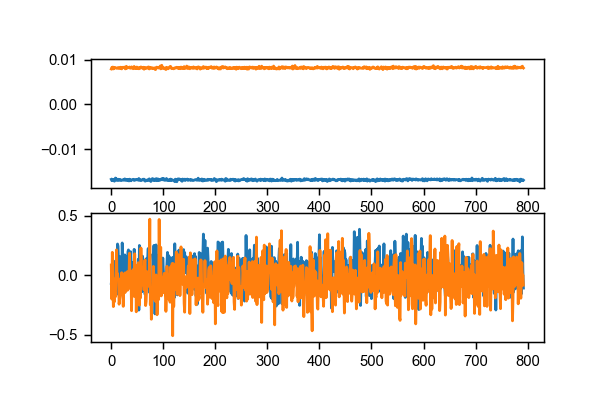

In [100]:
fig, axes = plt.subplots(2, 1)

ax = axes[0]
ax.plot(data[0, :, 0].real)
ax.plot(data[0, :, 0].imag)

ax = axes[1]
ax.plot(data[0, :, 1].real)
ax.plot(data[0, :, 1].imag)
# ax.plot(np.abs(data[0, :, 1]))

# Experiments

## Setup RF

In [101]:
# demod frequency
IF = 8e6

# experiment name
exp = select_experiment('readout_spec', SAMPLE)

# averaging
navgs = 10

# Spectroscopy frequencies
rf_frqs = np.linspace(435e6, 450e6, 101)[:]


In [102]:
### Set up the Sweeper

# AWG sampling rate (in Hz)
awg_spec_sweep.sample_rate(1e9)
# sequence length (in s). Up to buffers at the edges this is the integration time per AWG sweep.
awg_spec_sweep.seq_len(100e-6)
# and setup the sequence (will program the awg)
awg_spec_sweep.setup()

In [103]:
### Set up the detector

# det = iq_detector
# det = iqrel_detector
det = avgiq_detector
det.avg_buffers(False)

# set the sweeper
det.set_sweeper(awg_spec_sweep)
# acquisition time
det.acq_time(awg_spec_sweep.seq_len() - 2e-6)
# demod frequency
det.demod_frq(IF)
# HW config, and how data is shaped.
det.configure_alazar(
    records_per_buffer=1,
    buffers_per_acquisition=navgs,
)
det.setup()

print(det.sweep_dims, det.sweep_shape)

['awg_sweep_idx', 'channels'] (1, 2)


## Frequency scans and RF setup

### Sweep freq - resonator search

In [ ]:
# after setting up, we can create the measurement object.
# Note: we need to tell it ALL parameters and how they are related. 
# For simple cases, this wrapper does it.


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=det,
                      soft_sweep_params=[
                          het_src.frequency,
                      ])

# the measurement loop
meas.write_period = 1
with meas.run() as datasaver:
    
    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1)

    for f in rf_frqs:
        het_src.frequency(f)
        time.sleep(0.01)

        det.acquisition()
        datasaver.add_result(*meas.get_result())

### Frequency versus gate

In [ ]:
# after setting up, we can create the measurement object.
# Note: we need to tell it ALL parameters and how they are related. 
# For simple cases, this wrapper does it.


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=det,
                      soft_sweep_params=[
                          het_src.frequency,
                          ivvi_setup.dac7,
                      ])

lockin1.amplitude(0.004)
ivvi_setup.dac8(-0.47) #t3
ivvi_setup.dac10(0) #t2
ivvi_setup.dac11(-0.345) #t4
ivvi_setup.dac9(0) #t1
ivvi_setup.dac4(0e-3)

with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for r1 in np.linspace(-0.7e-3, 0.3e-3, 25):
        ivvi_setup.dac7(r1)

        for f in rf_frqs:
            het_src.frequency(f)
            time.sleep(0.01)

            det.acquisition()
            datasaver.add_result(*meas.get_result())

### Frequency versus magnetic field

In [ ]:
ami_x.pause()
ami_y.pause()
ami_z.pause()
ami.spherical([0,0,0])

In [ ]:
# after setting up, we can create the measurement object.
# Note: we need to tell it ALL parameters and how they are related. 
# For simple cases, this wrapper does it.


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=det,
                      soft_sweep_params=[
                          het_src.frequency,
                          ami.field,
                      ])

lockin1.amplitude(0.004)



with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for Bfield in np.linspace(0, 1, 21):
        ami.field(Bfield)

        for f in rf_frqs:
            het_src.frequency(f)
            time.sleep(0.02)

            det.acquisition()
            datasaver.add_result(*meas.get_result())

In [ ]:
ami_x.pause()
ami_y.pause()
ami_z.pause()
ami.spherical([0,0,0])

### RF gate sweep 

In [128]:
# after setting up, we can create the measurement object.
# Note: we need to tell it ALL parameters and how they are related. 
# For simple cases, this wrapper does it.


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=det,
                      soft_sweep_params=[
                          ivvi_setup.dac7,
                      ])


lockin1.amplitude(0.004)
ivvi_setup.dac4(0e-3)

ivvi_setup.dac9(0)     #t1
ivvi_setup.dac10(0)    #t2
ivvi_setup.dac8(-0.46) #t3
ivvi_setup.dac11(-0.32) #t4

het_src.frequency(443223813.84306061)


# the measurement loop
meas.write_period = 1
with meas.run() as datasaver:
    
    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )
    
    for r2 in np.linspace(0, 5e-3, 16*5):
        ivvi_setup.dac7(r2*1e-2)

        det.acquisition()
        datasaver.add_result(*meas.get_result())

Starting experimental run with id: 1094


### Tune RO attenuator

In [146]:
# after setting up, we can create the measurement object.
# Note: we need to tell it ALL parameters and how they are related. 
# For simple cases, this wrapper does it.


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=det,
                      soft_sweep_params=[
                          ivvi_setup.dac7,
                          ro_attenuator.attenuation,
                      ])


lockin1.amplitude(0.004)
ivvi_setup.dac4(0e-3)

ivvi_setup.dac9(0)     #t1
ivvi_setup.dac10(0)    #t2
ivvi_setup.dac8(-0.46) #t3
ivvi_setup.dac11(-0.32) #t4

het_src.frequency(443223813.84306061)


# the measurement loop
meas.write_period = 1
with meas.run() as datasaver:
    
    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )
    for att in np.linspace(55, 25, 31):
        ro_attenuator.attenuation(att)
        for r2 in np.linspace(0, 5e-3, 16*5):
            ivvi_setup.dac7(r2*1e-2)

            det.acquisition()
            datasaver.add_result(*meas.get_result())

Starting experimental run with id: 1096


ValueError: ("could not convert string to float: '\\x16\\x1fDEC9-2002'", 'getting ro_attenuator_attenuation')

## Hard sweeps

In [ ]:
### Sweeper
awg_ramp.sample_rate(1e7)
awg_ramp.step_len(400e-6)
awg_ramp.start_voltage(0)
awg_ramp.stop_voltage(.01)
awg_ramp.voltage_points(100)
awg_ramp.setup(start_awg=False)

print('frequency ' + str(1/(awg_ramp.step_len()*awg_ramp.voltage_points())) + " Hz")

In [ ]:
### Set up the detector

det1 = avgiq_detector
det1.avg_buffers(False)

det1.set_sweeper(awg_ramp)
# acquisition time
det1.acq_time(awg_ramp.step_len() - 1e-6)
# demod frequency
det1.demod_frq(IF)
# HW config, and how data is shaped.
det1.configure_alazar(
    records_per_buffer=awg_ramp.voltage_points(),
    buffers_per_acquisition=100,
)

det1.setup()

print(det1.sweep_dims, det1.sweep_shape)

### Diamonds scan

In [166]:
# after setting up, we can create the measurement object.
# Note: we need to tell it ALL parameters and how they are related. 
# For simple cases, this wrapper does it.


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=det1,
                      soft_sweep_params=[
                          ivvi_setup.dac4,
                      ])


lockin1.amplitude(0.004)
ivvi_setup.dac4(0e-3)

ivvi_setup.dac9(0)     #t1
ivvi_setup.dac10(0)    #t2
ivvi_setup.dac8(-0.46) #t3
ivvi_setup.dac11(-0.32) #t4

het_src.frequency(443223813.84306061)

# the measurement loop
meas.write_period = 1

with meas.run() as datasaver:
    
    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for bias in np.linspace(-.5e-3, .5e-3, 51):
        ivvi_setup.dac4(bias)

        det1.acquisition()
        datasaver.add_result(*meas.get_result())

Starting experimental run with id: 1098


### Charge stability diagram

In [172]:
# after setting up, we can create the measurement object.
# Note: we need to tell it ALL parameters and how they are related. 
# For simple cases, this wrapper does it.


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=det1,
                      soft_sweep_params=[
                          ivvi_setup.dac16,
                      ])


lockin1.amplitude(0.004)
ivvi_setup.dac4(0e-3)

ivvi_setup.dac9(0)     #t1
ivvi_setup.dac10(-0.3) #t2
ivvi_setup.dac8(-0.46) #t3
ivvi_setup.dac11(-0.5) #t4

het_src.frequency(443223813.84306061)

# the measurement loop
meas.write_period = 1

with meas.run() as datasaver:
    
    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for pg in np.linspace(0e-3, 1e-3, 51):
        ivvi_setup.dac16(pg)

        det1.acquisition()
        datasaver.add_result(*meas.get_result())

Starting experimental run with id: 1100


## RF diamond scan

In [104]:
# after setting up, we can create the measurement object.
# Note: we need to tell it ALL parameters and how they are related. 
# For simple cases, this wrapper does it.


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=det,
                      soft_sweep_params=[
                          ivvi_setup.dac4,
                          ivvi_setup.dac7,
                      ])


lockin1.amplitude(0.004)
ivvi_setup.dac4(0e-3)

ivvi_setup.dac9(0)     #t1
ivvi_setup.dac10(0)    #t2
ivvi_setup.dac8(-0.46) #t3
ivvi_setup.dac11(-0.32) #t4

het_src.frequency(443223813.84306061)

# the measurement loop
meas.write_period = 1

with meas.run() as datasaver:
    
    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for r2 in np.linspace(0, 2e-3, 21):
        ivvi_setup.dac7(r2*1e-2)
        for bias in np.linspace(-.5e-3, .5e-3, 51):
            ivvi_setup.dac4(bias)

            det.acquisition()
            datasaver.add_result(*meas.get_result())

Starting experimental run with id: 1085


KeyboardInterrupt: 

In [180]:
# after setting up, we can create the measurement object.
# Note: we need to tell it ALL parameters and how they are related. 
# For simple cases, this wrapper does it.


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=det,
                      soft_sweep_params=[
                          ivvi_setup.dac4,
                          ivvi_setup.dac8,
                      ])


lockin1.amplitude(0.004)
ivvi_setup.dac4(0e-3)

ivvi_setup.dac9(0)     #t1
ivvi_setup.dac10(0)    #t2
ivvi_setup.dac8(-0.55) #t3
ivvi_setup.dac11(-0.25) #t4

het_src.frequency(443223813.84306061)

# the measurement loop
meas.write_period = 1

T3 = np.linspace(-.500,-.400,6)
T4 = np.linspace(-.350,-.300,6)
                    
for t4 in T4:
    ivvi_setup.dac11(t4)
    for t3 in T3:
        ivvi_setup.dac8(t3)
        with meas.run() as datasaver:

            datasaver.dataset.subscribe(
                QcodesDatasetSubscriber(datasaver.dataset), 
                state=[], min_wait=0, min_count=1,
            )

            for r2 in np.linspace(0, 5e-3, 101):
                ivvi_setup.dac8(r2)
                for bias in np.linspace(-.5e-3, .5e-3, 101):
                    ivvi_setup.dac4(bias)

                    det.acquisition()
                    datasaver.add_result(*meas.get_result())

Starting experimental run with id: 1103


RuntimeError: ('error 579: ApiWaitTimeout: operation did not finish during timeout interval. Check your trigger. from function AlazarWaitAsyncBufferComplete with args: [2640, c_void_p(2811056095232), 10000]', 'getting avgiq_acq_acquisition', 'getting avgiq_detector_acquisition')

In [ ]:
# after setting up, we can create the measurement object.
# Note: we need to tell it ALL parameters and how they are related. 
# For simple cases, this wrapper does it.


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=det,
                      soft_sweep_params=[
                          ivvi_setup.dac4,
                          ivvi_setup.dac7,
                      ])


lockin1.amplitude(0.004)
ivvi_setup.dac4(0e-3)

ivvi_setup.dac9(0)     #t1
ivvi_setup.dac10(0)    #t2
ivvi_setup.dac8(-0.55) #t3
ivvi_setup.dac11(-0.25) #t4

het_src.frequency(443223813.84306061)

# the measurement loop
meas.write_period = 1

T3 = [-0.4, -0.45]
T4 = np.linspace(-.400,-.300,6)

for t4 in T4:
    ivvi_setup.dac11(t4)
    for t3 in T3:
        ivvi_setup.dac8(t3)
        with meas.run() as datasaver:

            datasaver.dataset.subscribe(
                QcodesDatasetSubscriber(datasaver.dataset), 
                state=[], min_wait=0, min_count=1,
            )

            for r2 in np.linspace(0, 5e-3, 51):
                ivvi_setup.dac7(r2)
                for bias in np.linspace(-15e-3, 15e-3, 51):
                    ivvi_setup.dac4(bias)

                    det.acquisition()
                    datasaver.add_result(*meas.get_result())
                    
for t4 in T4:
    ivvi_setup.dac11(t4)
    for t3 in T3:
        ivvi_setup.dac8(t3)
        with meas.run() as datasaver:

            datasaver.dataset.subscribe(
                QcodesDatasetSubscriber(datasaver.dataset), 
                state=[], min_wait=0, min_count=1,
            )

            for r2 in np.linspace(0, 5e-3, 101):
                ivvi_setup.dac7(r2)
                for bias in np.linspace(-.5e-3, .5e-3, 51):
                    ivvi_setup.dac4(bias)

                    det.acquisition()
                    datasaver.add_result(*meas.get_result())

### Map rf diamonds in 2D pinchoff

In [ ]:
# after setting up, we can create the measurement object.
# Note: we need to tell it ALL parameters and how they are related. 
# For simple cases, this wrapper does it.


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=det,
                      soft_sweep_params=[
                          ivvi_setup.dac4,
                          ivvi_setup.dac7,
                      ])


lockin1.amplitude(0.004)
ivvi_setup.dac4(0e-3)
ivvi_setup.dac8(-0.47) #t3
ivvi_setup.dac10(0) #t2
ivvi_setup.dac11(-0.345) #t4
ivvi_setup.dac9(0) #t1
het_src.frequency(442.996e6)

# the measurement loop
meas.write_period = 1

with meas.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for r2 in np.linspace(0, 3e-3, 101):
        ivvi_setup.dac7(r2)
        for bias in np.linspace(-.5e-3, .5e-3, 101):
            ivvi_setup.dac4(bias)

            det.acquisition()
            datasaver.add_result(*meas.get_result())

## RF Charge stability diagram

In [ ]:
# after setting up, we can create the measurement object.
# Note: we need to tell it ALL parameters and how they are related. 
# For simple cases, this wrapper does it.


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=det,
                      soft_sweep_params=[
                          ivvi_setup.dac16,
                          ivvi_setup.dac7,
                      ])


lockin1.amplitude(0.004)
ivvi_setup.dac4(0e-3)
ivvi_setup.dac8(-0.46) #t3
ivvi_setup.dac10(-0.3) #t2
ivvi_setup.dac11(-0.5) #t4
ivvi_setup.dac9(0) #t1
het_src.frequency(436588983.83)

# the measurement loop
meas.write_period = 1


with meas.run() as datasaver:
    
    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for r2 in np.linspace(-1e-3, 1e-3, 25):
        ivvi_setup.dac7(r2)
        for pg in np.linspace(0e-3, 1e-3, 51):
            ivvi_setup.dac16(pg)

            det.acquisition()
            datasaver.add_result(*meas.get_result())

### RF CSD vs field

In [ ]:
ami_x.pause()
ami_y.pause()
ami_z.pause()
ami.spherical([0,-2,90])

In [ ]:
# after setting up, we can create the measurement object.
# Note: we need to tell it ALL parameters and how they are related. 
# For simple cases, this wrapper does it.


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=det,
                      soft_sweep_params=[
                          ivvi_setup.dac16,
                          ivvi_setup.dac7,
                      ])


lockin1.amplitude(0.004)
ivvi_setup.dac4(0e-3)
ivvi_setup.dac8(-0.46) #t3
ivvi_setup.dac10(-0.31) #t2
ivvi_setup.dac11(-0.41) #t4
ivvi_setup.dac9(0) #t1
het_src.frequency(442.996e6)

# the measurement loop
meas.write_period = 1

fields = np.linspace(0,1,11)

for field in fields:
    ami.field(field)
    
    with meas.run() as datasaver:

        datasaver.dataset.subscribe(
            QcodesDatasetSubscriber(datasaver.dataset), 
            state=[], min_wait=0, min_count=1,
        )

        for r2 in np.linspace(-1e-3, 1e-3, 101):
            ivvi_setup.dac7(r2)
            for pg in np.linspace(0e-3, 1e-3, 101):
                ivvi_setup.dac16(pg)

                det.acquisition()
                datasaver.add_result(*meas.get_result())

In [ ]:
ami_x.pause()
ami_y.pause()
ami_z.pause()
ami.spherical([0,0,0])

In [ ]:
# after setting up, we can create the measurement object.
# Note: we need to tell it ALL parameters and how they are related. 
# For simple cases, this wrapper does it.


meas = MeasurementExt(station, exp=exp, 
                      hard_sweep_detector=det,
                      soft_sweep_params=[
                          ivvi_setup.dac16,
                          ivvi_setup.dac7,
                      ])


lockin1.amplitude(0.004)
ivvi_setup.dac4(0e-3)
ivvi_setup.dac8(-0.46) #t3
ivvi_setup.dac10(-0.31) #t2
ivvi_setup.dac11(-0.41) #t4
ivvi_setup.dac9(0) #t1
het_src.frequency(442.996e6)

# the measurement loop
meas.write_period = 1

fields = np.linspace(0,1,5)

for field in fields:
    ami.field(field)
    
    with meas.run() as datasaver:

        datasaver.dataset.subscribe(
            QcodesDatasetSubscriber(datasaver.dataset), 
            state=[], min_wait=0, min_count=1,
        )

        for r2 in np.linspace(-1e-3, 1e-3, 101):
            ivvi_setup.dac7(r2)
            for pg in np.linspace(0e-3, 1e-3, 101):
                ivvi_setup.dac16(pg)

                det.acquisition()
                datasaver.add_result(*meas.get_result())

## DC diamond scans

### DC Diamonds SC

In [ ]:
exp = select_experiment('R2', 'Cq334M')

meas = Measurement(exp=exp)
meas.write_period = 1
meas.register_parameter(ivvi_setup.dac5)
meas.register_parameter(ivvi_setup.dac4)
meas.register_parameter(ivvi_setup.i_measurement, setpoints=[ivvi_setup.dac5, ivvi_setup.dac4])
meas.register_parameter(ivvi_setup.ig_measurement, setpoints=[ivvi_setup.dac5, ivvi_setup.dac4])
meas.register_parameter(ivvi_setup.g_measurement, setpoints=[ivvi_setup.dac5, ivvi_setup.dac4])

lockin1.amplitude(0.05)
ivvi_setup.dac8(-0.47) #t3
ivvi_setup.dac10(-0.32) #t2

pg = np.linspace(-1e-3, 1e-3, 51)
bias_values = np.linspace(-.5e-3, .5e-3, 101)
with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    
    for s1 in pg:
        ivvi_setup.dac5(s1)
        for s2 in bias_values:
            ivvi_setup.dac4(s2)
            datasaver.add_result((ivvi_setup.dac5, s1),
                                 (ivvi_setup.dac4, s2), 
                                 (ivvi_setup.i_measurement, ivvi_setup.i_measurement()),
                                 (ivvi_setup.ig_measurement, ivvi_setup.ig_measurement()),
                                 (ivvi_setup.g_measurement, ivvi_setup.g_measurement()))

### DC Diamonds dot 1

In [ ]:
exp = select_experiment('R2', 'Cq334M')

meas = Measurement(exp=exp)
meas.write_period = 1
meas.register_parameter(ivvi_setup.dac7)
meas.register_parameter(ivvi_setup.dac4)
meas.register_parameter(ivvi_setup.i_measurement, setpoints=[ivvi_setup.dac7, ivvi_setup.dac4])
meas.register_parameter(ivvi_setup.ig_measurement, setpoints=[ivvi_setup.dac7, ivvi_setup.dac4])
meas.register_parameter(ivvi_setup.g_measurement, setpoints=[ivvi_setup.dac7, ivvi_setup.dac4])


lockin1.amplitude(0.05)
ivvi_setup.dac8(0) #t3
ivvi_setup.dac10(-0.32) #t2
ivvi_setup.dac9(-0.32) #t1
ivvi_setup.dac4(1e-3)

pg = np.linspace(0, 1e-3, 25)
bias_values = np.linspace(-.5e-3, .5e-3, 101)
with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    
    for s1 in pg:
        ivvi_setup.dac7(s1)
        for s2 in bias_values:
            ivvi_setup.dac4(s2)
            datasaver.add_result((ivvi_setup.dac7, s1),
                                 (ivvi_setup.dac4, s2), 
                                 (ivvi_setup.i_measurement, ivvi_setup.i_measurement()),
                                 (ivvi_setup.ig_measurement, ivvi_setup.ig_measurement()),
                                 (ivvi_setup.g_measurement, ivvi_setup.g_measurement()))

### DC Diamonds dot 2

In [ ]:
exp = select_experiment('R2', 'Cq334M')

meas = Measurement(exp=exp)
meas.write_period = 1
meas.register_parameter(ivvi_setup.dac14)
meas.register_parameter(ivvi_setup.dac4)
meas.register_parameter(ivvi_setup.i_measurement, setpoints=[ivvi_setup.dac14, ivvi_setup.dac4])
meas.register_parameter(ivvi_setup.ig_measurement, setpoints=[ivvi_setup.dac14, ivvi_setup.dac4])
meas.register_parameter(ivvi_setup.g_measurement, setpoints=[ivvi_setup.dac14, ivvi_setup.dac4])


lockin1.amplitude(0.05)
lockin1.frequency(21.2)
ivvi_setup.dac8(0) #t3
ivvi_setup.dac10(-0.33) #t2
ivvi_setup.dac11(-0.35) #t4
ivvi_setup.dac9(0) #t1
ivvi_setup.dac4(1e-3)

pg = np.linspace(0, 1e-3, 16)
bias_values = np.linspace(-.5e-3, .5e-3, 101)
with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    
    for s1 in pg:
        ivvi_setup.dac14(s1)
        for s2 in bias_values:
            ivvi_setup.dac4(s2)
            datasaver.add_result((ivvi_setup.dac14, s1),
                                 (ivvi_setup.dac4, s2), 
                                 (ivvi_setup.i_measurement, ivvi_setup.i_measurement()),
                                 (ivvi_setup.ig_measurement, ivvi_setup.ig_measurement()),
                                 (ivvi_setup.g_measurement, ivvi_setup.g_measurement()))

## DC Charge stability diagram

In [175]:
# after setting up, we can create the measurement object.
# Note: we need to tell it ALL parameters and how they are related. 
# For simple cases, this wrapper does it.


meas = Measurement(exp=exp)
meas.write_period = 1
meas.register_parameter(ivvi_setup.dac7)
meas.register_parameter(ivvi_setup.dac16)
meas.register_parameter(ivvi_setup.i_measurement, setpoints=[ivvi_setup.dac7, ivvi_setup.dac16])
meas.register_parameter(ivvi_setup.ig_measurement, setpoints=[ivvi_setup.dac7, ivvi_setup.dac16])
meas.register_parameter(ivvi_setup.g_measurement, setpoints=[ivvi_setup.dac7, ivvi_setup.dac16])


lockin1.amplitude(0.1)
lockin1.frequency(21.2)
ivvi_setup.dac4(0e-3)

ivvi_setup.dac9(0)     #t1
ivvi_setup.dac10(-0.3) #t2
ivvi_setup.dac8(-0.46) #t3
ivvi_setup.dac11(-0.5) #t4

# the measurement loop
meas.write_period = 1


with meas.run() as datasaver:
    
    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for r2 in np.linspace(0e-3, 1e-3, 16):
        ivvi_setup.dac7(r2*1e-2)
        for pg in np.linspace(0e-3, 1e-3, 51):
            ivvi_setup.dac16(pg)
            datasaver.add_result((ivvi_setup.dac7, r2),
                                 (ivvi_setup.dac16, pg), 
                                 (ivvi_setup.i_measurement, ivvi_setup.i_measurement()),
                                 (ivvi_setup.ig_measurement, ivvi_setup.ig_measurement()),
                                 (ivvi_setup.g_measurement, ivvi_setup.g_measurement()))

Starting experimental run with id: 1102


## DC field sweeps

In [179]:
ivvi.set_dacs_zero()

### Gap measurement versus punger G

In [ ]:
exp = select_experiment('Cq334L', 'Gap measurement')

meas = Measurement(exp=exp)
meas.write_period = 1
meas.register_parameter(ivvi_setup.dac15)
meas.register_parameter(ivvi_setup.dac4)
meas.register_parameter(ivvi_setup.i_measurement, setpoints=[ivvi_setup.dac15, ivvi_setup.dac4])
meas.register_parameter(ivvi_setup.ig_measurement, setpoints=[ivvi_setup.dac15, ivvi_setup.dac4])
meas.register_parameter(ivvi_setup.g_measurement, setpoints=[ivvi_setup.dac15, ivvi_setup.dac4])


lockin1.amplitude(0.05)
lockin1.frequency(21.2)

ivvi_setup.dac9(0)      #t1
ivvi_setup.dac10(0) #t2
ivvi_setup.dac8(-0.46)      #t3
ivvi_setup.dac11(0)     #t4
ivvi_setup.dac15(0)
ivvi_setup.dac4(1e-3)

gate_values = np.linspace(-0.045, -0.05, 51)
bias_values = np.linspace(-0.3e-3, 0.3e-3, 101)
with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    
    for s1 in gate_values:
        ivvi_setup.dac15(s1)
        for s2 in bias_values:
            ivvi_setup.dac4(s2)
            datasaver.add_result((ivvi_setup.dac15, s1),
                                 (ivvi_setup.dac4, s2), 
                                 (ivvi_setup.i_measurement, ivvi_setup.i_measurement()),
                                 (ivvi_setup.ig_measurement, ivvi_setup.ig_measurement()),
                                 (ivvi_setup.g_measurement, ivvi_setup.g_measurement()))

### Gap measurement versus tunnel gate

#### T3

In [ ]:
exp = select_experiment('Cq334L', 'Gap measurement')

meas = Measurement(exp=exp)
meas.write_period = 1
meas.register_parameter(ivvi_setup.dac8)
meas.register_parameter(ivvi_setup.dac4)
meas.register_parameter(ivvi_setup.i_measurement, setpoints=[ivvi_setup.dac8, ivvi_setup.dac4])
meas.register_parameter(ivvi_setup.ig_measurement, setpoints=[ivvi_setup.dac8, ivvi_setup.dac4])
meas.register_parameter(ivvi_setup.g_measurement, setpoints=[ivvi_setup.dac8, ivvi_setup.dac4])


lockin1.amplitude(0.05)
lockin1.frequency(21.2)

ivvi_setup.dac9(0.4)      #t1
ivvi_setup.dac10(0.2) #t2
ivvi_setup.dac8(-0.46)      #t3
ivvi_setup.dac11(0.2)     #t4
ivvi_setup.dac15(-0.75)
ivvi_setup.dac4(1e-3)

gate_values = np.linspace(-0.44, -0.46, 10)
bias_values = np.linspace(-0.6e-3, 0.6e-3, 101)
with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    
    for s1 in gate_values:
        ivvi_setup.dac8(s1)
        for s2 in bias_values:
            ivvi_setup.dac4(s2)
            datasaver.add_result((ivvi_setup.dac8, s1),
                                 (ivvi_setup.dac4, s2), 
                                 (ivvi_setup.i_measurement, ivvi_setup.i_measurement()),
                                 (ivvi_setup.ig_measurement, ivvi_setup.ig_measurement()),
                                 (ivvi_setup.g_measurement, ivvi_setup.g_measurement()))

#### T2

In [ ]:
exp = select_experiment('Cq334L', 'Gap measurement')

meas = Measurement(exp=exp)
meas.write_period = 1
meas.register_parameter(ivvi_setup.dac10)
meas.register_parameter(ivvi_setup.dac4)
meas.register_parameter(ivvi_setup.i_measurement, setpoints=[ivvi_setup.dac10, ivvi_setup.dac4])
meas.register_parameter(ivvi_setup.ig_measurement, setpoints=[ivvi_setup.dac10, ivvi_setup.dac4])
meas.register_parameter(ivvi_setup.g_measurement, setpoints=[ivvi_setup.dac10, ivvi_setup.dac4])


lockin1.amplitude(0.05)
lockin1.frequency(21.2)

ivvi_setup.dac9(0.4)      #t1
ivvi_setup.dac10(0.2) #t2
ivvi_setup.dac8(-0.46)      #t3
ivvi_setup.dac11(0.2)     #t4
ivvi_setup.dac15(-0.75)
ivvi_setup.dac4(1e-3)

gate_values = np.linspace(0.4, 0.6, 10)
bias_values = np.linspace(-0.6e-3, 0.6e-3, 101)
with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    
    for s1 in gate_values:
        ivvi_setup.dac10(s1)
        for s2 in bias_values:
            ivvi_setup.dac4(s2)
            datasaver.add_result((ivvi_setup.dac10, s1),
                                 (ivvi_setup.dac4, s2), 
                                 (ivvi_setup.i_measurement, ivvi_setup.i_measurement()),
                                 (ivvi_setup.ig_measurement, ivvi_setup.ig_measurement()),
                                 (ivvi_setup.g_measurement, ivvi_setup.g_measurement()))

#### T4

In [ ]:
exp = select_experiment('Cq334L', 'Gap measurement')

meas = Measurement(exp=exp)
meas.write_period = 1
meas.register_parameter(ivvi_setup.dac11)
meas.register_parameter(ivvi_setup.dac4)
meas.register_parameter(ivvi_setup.i_measurement, setpoints=[ivvi_setup.dac11, ivvi_setup.dac4])
meas.register_parameter(ivvi_setup.ig_measurement, setpoints=[ivvi_setup.dac11, ivvi_setup.dac4])
meas.register_parameter(ivvi_setup.g_measurement, setpoints=[ivvi_setup.dac11, ivvi_setup.dac4])


lockin1.amplitude(0.05)
lockin1.frequency(21.2)

ivvi_setup.dac9(0.4)      #t1
ivvi_setup.dac10(0.6) #t2
ivvi_setup.dac8(-0.46)      #t3
ivvi_setup.dac11(0.2)     #t4
ivvi_setup.dac15(-0.75)
ivvi_setup.dac4(1e-3)

gate_values = np.linspace(0.2, 0.6, 10)
bias_values = np.linspace(-0.6e-3, 0.6e-3, 101)
with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    
    for s1 in gate_values:
        ivvi_setup.dac11(s1)
        for s2 in bias_values:
            ivvi_setup.dac4(s2)
            datasaver.add_result((ivvi_setup.dac11, s1),
                                 (ivvi_setup.dac4, s2), 
                                 (ivvi_setup.i_measurement, ivvi_setup.i_measurement()),
                                 (ivvi_setup.ig_measurement, ivvi_setup.ig_measurement()),
                                 (ivvi_setup.g_measurement, ivvi_setup.g_measurement()))

### DC theta versus bias

In [ ]:
ami_x.pause()
ami_y.pause()
ami_z.pause()
ami.spherical([0.9,20,90])

In [ ]:
exp = select_experiment('Cq334L', 'Field align')

meas = Measurement(exp=exp)
meas.write_period = 1
meas.register_parameter(ivvi_setup.dac4)
meas.register_parameter(ami.theta)
meas.register_parameter(ivvi_setup.i_measurement, setpoints=[ami.theta, ivvi_setup.dac4])
meas.register_parameter(ivvi_setup.ig_measurement, setpoints=[ami.theta, ivvi_setup.dac4])
meas.register_parameter(ivvi_setup.g_measurement, setpoints=[ami.theta, ivvi_setup.dac4])

lockin1.amplitude(0.05)
lockin1.frequency(21.2)

ivvi_setup.dac9(0.4)      #t1
ivvi_setup.dac10(0.6) #t2
ivvi_setup.dac8(-0.46)      #t3
ivvi_setup.dac11(0.2)     #t4
ivvi_setup.dac15(-0.75)
ivvi_setup.dac4(1e-3)

theta_vals = np.linspace(20, -20, 40)
bias_values = np.linspace(-.4e-3, .4e-3, 101)
with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    
    for s1 in theta_vals:
        ami.theta(s1)
        for s2 in bias_values:
            ivvi_setup.dac4(s2)
            datasaver.add_result((ami.theta, s1),
                                 (ivvi_setup.dac4, s2), 
                                 (ivvi_setup.i_measurement, ivvi_setup.i_measurement()),
                                 (ivvi_setup.ig_measurement, ivvi_setup.ig_measurement()),
                                 (ivvi_setup.g_measurement, ivvi_setup.g_measurement()))

### DC field magnitude versus bias

In [ ]:
ami_x.pause()
ami_y.pause()
ami_z.pause()
ami.spherical([0,-2,90])

In [ ]:
exp = select_experiment('Cq334L', 'Field align')

meas = Measurement(exp=exp)
meas.write_period = 1
meas.register_parameter(ami.field)
meas.register_parameter(ivvi_setup.dac4)
meas.register_parameter(ivvi_setup.i_measurement, setpoints=[ami.field, ivvi_setup.dac4])
meas.register_parameter(ivvi_setup.ig_measurement, setpoints=[ami.field, ivvi_setup.dac4])
meas.register_parameter(ivvi_setup.g_measurement, setpoints=[ami.field, ivvi_setup.dac4])

lockin1.amplitude(0.05)
lockin1.frequency(21.2)

ivvi_setup.dac9(0.4)      #t1
ivvi_setup.dac10(0.6) #t2
ivvi_setup.dac8(-0.46)      #t3
ivvi_setup.dac11(0.2)     #t4
ivvi_setup.dac15(-0.75)
ivvi_setup.dac4(1e-3)

Br_vals = np.linspace(1.99, 0, 101)
bias_values = np.linspace(-.4e-3, .4e-3, 101)
with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    
    for s1 in Br_vals:
        ami.field(s1)
        for s2 in bias_values:
            ivvi_setup.dac4(s2)
            datasaver.add_result((ami.field, s1),
                                 (ivvi_setup.dac4, s2), 
                                 (ivvi_setup.i_measurement, ivvi_setup.i_measurement()),
                                 (ivvi_setup.ig_measurement, ivvi_setup.ig_measurement()),
                                 (ivvi_setup.g_measurement, ivvi_setup.g_measurement()))

## Gate vs gate

In [182]:
ivvi.set_dacs_zero()

### G vs T2

In [ ]:
exp = select_experiment('G vs T2', 'Cq334L')

meas = Measurement(exp=exp)
meas.write_period = 1
meas.register_parameter(ivvi_setup.dac10)
meas.register_parameter(ivvi_setup.dac15)
meas.register_parameter(ivvi_setup.i_measurement, setpoints=[ivvi_setup.dac10, ivvi_setup.dac15])
# meas.register_parameter(ivvi_setup.ig_measurement, setpoints=[ivvi_setup.dac10, ivvi_setup.dac15])
# meas.register_parameter(ivvi_setup.g_measurement, setpoints=[ivvi_setup.dac10, ivvi_setup.dac15])


lockin1.amplitude(0.05)
lockin1.frequency(21.2)
ivvi_setup.dac4(1e-3)

G  = np.linspace(0, -1, 41)
T2 = np.linspace(0, -0.35, 51)
with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    
    for s1 in G:
        ivvi_setup.dac15(s1)
        for s2 in T2:
            ivvi_setup.dac10(s2)
            datasaver.add_result((ivvi_setup.dac10, s1),
                                 (ivvi_setup.dac15, s2), 
                                 (ivvi_setup.i_measurement, ivvi_setup.i_measurement()),
                                )
#                                  (ivvi_setup.ig_measurement, ivvi_setup.ig_measurement()),
#                                  (ivvi_setup.g_measurement, ivvi_setup.g_measurement()))

### G vs T3

In [ ]:
ivvi.set_dacs_zero()

exp = select_experiment('G vs T3', 'Cq334L')

meas = Measurement(exp=exp)
meas.write_period = 1
meas.register_parameter(ivvi_setup.dac8)
meas.register_parameter(ivvi_setup.dac15)
meas.register_parameter(ivvi_setup.i_measurement, setpoints=[ivvi_setup.dac8, ivvi_setup.dac15])
# meas.register_parameter(ivvi_setup.ig_measurement, setpoints=[ivvi_setup.dac10, ivvi_setup.dac15])
# meas.register_parameter(ivvi_setup.g_measurement, setpoints=[ivvi_setup.dac10, ivvi_setup.dac15])


lockin1.amplitude(0.05)
lockin1.frequency(21.2)
ivvi_setup.dac4(1e-3)

G  = np.linspace(0, -1, 41)
T3 = np.linspace(0, -0.5, 51)
with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    
    for s1 in G:
        ivvi_setup.dac15(s1)
        for s2 in T3:
            ivvi_setup.dac8(s2)
            datasaver.add_result((ivvi_setup.dac8, s1),
                                 (ivvi_setup.dac15, s2), 
                                 (ivvi_setup.i_measurement, ivvi_setup.i_measurement()),
                                )
#                                  (ivvi_setup.ig_measurement, ivvi_setup.ig_measurement()),
#                                  (ivvi_setup.g_measurement, ivvi_setup.g_measurement()))


### T2 vs T3

In [ ]:
ivvi.set_dacs_zero()

exp = select_experiment('G vs T3', 'Cq334L')

meas = Measurement(exp=exp)
meas.write_period = 1
meas.register_parameter(ivvi_setup.dac8)
meas.register_parameter(ivvi_setup.dac10)
meas.register_parameter(ivvi_setup.i_measurement, setpoints=[ivvi_setup.dac8, ivvi_setup.dac10])
# meas.register_parameter(ivvi_setup.ig_measurement, setpoints=[ivvi_setup.dac10, ivvi_setup.dac15])
# meas.register_parameter(ivvi_setup.g_measurement, setpoints=[ivvi_setup.dac10, ivvi_setup.dac15])


lockin1.amplitude(0.05)
lockin1.frequency(21.2)
ivvi_setup.dac4(1e-3)
ivvi_setup.dac15(0)

T2 = np.linspace(1, 0, 51)
T3 = np.linspace(0.5, -0.5, 101)
with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    
    for s1 in T2:
        ivvi_setup.dac10(s1)
        for s2 in T3:
            ivvi_setup.dac8(s2)
            datasaver.add_result((ivvi_setup.dac8, s1),
                                 (ivvi_setup.dac10, s2), 
                                 (ivvi_setup.i_measurement, ivvi_setup.i_measurement()),
                                )
#                                  (ivvi_setup.ig_measurement, ivvi_setup.ig_measurement()),
#                                  (ivvi_setup.g_measurement, ivvi_setup.g_measurement()))

### T3 vs T4

In [ ]:
ivvi.set_dacs_zero()

exp = select_experiment('T4 vs T3', 'Cq334L')

meas = Measurement(exp=exp)
meas.write_period = 1
meas.register_parameter(ivvi_setup.dac8)
meas.register_parameter(ivvi_setup.dac11)
meas.register_parameter(ivvi_setup.i_measurement, setpoints=[ivvi_setup.dac8, ivvi_setup.dac11])
# meas.register_parameter(ivvi_setup.ig_measurement, setpoints=[ivvi_setup.dac10, ivvi_setup.dac15])
# meas.register_parameter(ivvi_setup.g_measurement, setpoints=[ivvi_setup.dac10, ivvi_setup.dac15])


lockin1.amplitude(0.05)
lockin1.frequency(21.2)
ivvi_setup.dac4(1e-3)
ivvi_setup.dac15(0)

T4 = np.linspace(-0.15, -0.4,  101)
T3 = np.linspace(-0.25, -0.55, 101)
with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    
    for s1 in T4:
        ivvi_setup.dac11(s1)
        for s2 in T3:
            ivvi_setup.dac8(s2)
            datasaver.add_result((ivvi_setup.dac8, s1),
                                 (ivvi_setup.dac11, s2), 
                                 (ivvi_setup.i_measurement, ivvi_setup.i_measurement()),
                                )
#                                  (ivvi_setup.ig_measurement, ivvi_setup.ig_measurement()),
#                                  (ivvi_setup.g_measurement, ivvi_setup.g_measurement()))

### T2 vs T4

In [ ]:
ivvi.set_dacs_zero()

exp = select_experiment('T2 vs T4', 'Cq334L')

meas = Measurement(exp=exp)
meas.write_period = 1
meas.register_parameter(ivvi_setup.dac10)
meas.register_parameter(ivvi_setup.dac11)
meas.register_parameter(ivvi_setup.i_measurement, setpoints=[ivvi_setup.dac10, ivvi_setup.dac11])
# meas.register_parameter(ivvi_setup.ig_measurement, setpoints=[ivvi_setup.dac10, ivvi_setup.dac15])
# meas.register_parameter(ivvi_setup.g_measurement, setpoints=[ivvi_setup.dac10, ivvi_setup.dac15])


lockin1.amplitude(0.05)
lockin1.frequency(21.2)
ivvi_setup.dac4(1e-3)
ivvi_setup.dac15(0)

T4 = np.linspace(0, -0.4, 51)
T2 = np.linspace(0, -0.35, 101)
with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    
    for s1 in T4:
        ivvi_setup.dac11(s1)
        for s2 in T2:
            ivvi_setup.dac10(s2)
            datasaver.add_result((ivvi_setup.dac10, s1),
                                 (ivvi_setup.dac11, s2), 
                                 (ivvi_setup.i_measurement, ivvi_setup.i_measurement()),
                                )
#                                  (ivvi_setup.ig_measurement, ivvi_setup.ig_measurement()),
#                                  (ivvi_setup.g_measurement, ivvi_setup.g_measurement()))

### T1 vs T2

In [ ]:
ivvi.set_dacs_zero()

exp = select_experiment('T2 vs T4', 'Cq334L')

meas = Measurement(exp=exp)
meas.write_period = 1
meas.register_parameter(ivvi_setup.dac10)
meas.register_parameter(ivvi_setup.dac9)
meas.register_parameter(ivvi_setup.i_measurement, setpoints=[ivvi_setup.dac10, ivvi_setup.dac9])
# meas.register_parameter(ivvi_setup.ig_measurement, setpoints=[ivvi_setup.dac10, ivvi_setup.dac15])
# meas.register_parameter(ivvi_setup.g_measurement, setpoints=[ivvi_setup.dac10, ivvi_setup.dac15])


lockin1.amplitude(0.05)
lockin1.frequency(21.2)
ivvi_setup.dac4(1e-3)
ivvi_setup.dac15(0)

T1 = np.linspace(0, -0.4, 51)
T2 = np.linspace(0, -0.35, 101)
with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    
    for s1 in T1:
        ivvi_setup.dac9(s1)
        for s2 in T2:
            ivvi_setup.dac10(s2)
            datasaver.add_result((ivvi_setup.dac10, s1),
                                 (ivvi_setup.dac9, s2), 
                                 (ivvi_setup.i_measurement, ivvi_setup.i_measurement()),
                                )
#                                  (ivvi_setup.ig_measurement, ivvi_setup.ig_measurement()),
#                                  (ivvi_setup.g_measurement, ivvi_setup.g_measurement()))